In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn


from torch.optim import Adam
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from torch.utils.data import RandomSampler, Dataset, DataLoader

In [3]:
df = pd.read_json("answer_generation.json")
df["data"][0]

{'title': 'Điều 1 36/2005/QH11 thương mại',
 'paragraphs': [{'context': 'Phạm vi điều chỉnh 1. Hoạt động thương mại thực hiện trên lãnh thổ nước Cộng hoà xã hội chủ nghĩa Việt Nam. 2. Hoạt động thương mại thực hiện ngoài lãnh thổ nước Cộng hoà xã hội chủ nghĩa Việt Nam trong trường hợp các bên thoả thuận chọn áp dụng Luật này hoặc luật nước ngoài, điều ước quốc tế mà Cộng hoà xã hội chủ nghĩa Việt Nam là thành viên có quy định áp dụng Luật này. 3. Hoạt động không nhằm mục đích sinh lợi của một bên trong giao dịch với thương nhân thực hiện trên lãnh thổ nước Cộng hoà xã hội chủ nghĩa Việt Nam trong trường hợp bên thực hiện hoạt động không nhằm mục đích sinh lợi đó chọn áp dụng Luật này.',
   'qas': [{'question': 'Điều khoản nào trong luật thương mại Việt Nam quy định về việc thay đổi hợp đồng kinh doanh liên quan đến thanh toán tiền?',
     'id': '282f878f09a831f58e0b8bac3ca5ca40',
     'answers': [{'text': 'Điều 405 của Bộ luật dân sự Việt Nam.'}]},
    {'question': 'định nghĩa phạm vi

In [4]:
questions = []
contexts = []
answers = []
for data_obj in df["data"]:
    for para in data_obj["paragraphs"]:
        context = para["context"]
        for qa in para["qas"]:
            question = qa["question"]
            for ans in qa["answers"]:
                questions.append(question)
                contexts.append(context)
                answers.append(ans["text"])

print(len(questions))
print(len(contexts))
print(len(answers))


648
648
648


In [5]:
data = pd.DataFrame({"question": questions, "context": contexts, "answer": answers})
data.head()

,question,context,answer
0,Điều khoản nào trong luật thương mại Việt Nam ...,Phạm vi điều chỉnh 1. Hoạt động thương mại thự...,Điều 405 của Bộ luật dân sự Việt Nam.
1,định nghĩa phạm vi điều chỉnh trong luật pháp?,Phạm vi điều chỉnh 1. Hoạt động thương mại thự...,Phạm vi điều chỉnh là phạm vi áp dụng của một ...
2,Tương tác trong lĩnh vực thương mại Việt Nam l...,Đối tượng áp dụng 1. Thương nhân hoạt động thư...,Tương tác trong lĩnh vực thương mại Việt Nam b...
3,Luật thương mại có liên quan đến lĩnh vực nào?,Đối tượng áp dụng 1. Thương nhân hoạt động thư...,Luật thương mại liên quan đến lĩnh vực kinh do...
4,Sự khác biệt giữa hợp đồng mua bán hàng hóa và...,"Trong Luật này, các từ ngữ dưới đây được hiểu ...",Hợp đồng mua bán hàng hóa và hợp đồng cung cấp...


In [6]:
# Create DataFrame
data = pd.DataFrame({"question": questions, "context": contexts, "answer": answers})

# Define word count limits
context_word_limit = 512
answer_word_limit = 128

# Function to count words
def word_count(text):
    return len(text.split())

# Apply the word count function
data['context_word_count'] = data['context'].apply(word_count)
data['answer_word_count'] = data['answer'].apply(word_count)

# Count contexts and answers exceeding the word limits
num_contexts_over_limit = (data['context_word_count'] > context_word_limit).sum()
num_answers_over_limit = (data['answer_word_count'] > answer_word_limit).sum()

# Calculate total number of contexts and answers
total_contexts = len(data)
total_answers = len(data)

# Calculate percentages
percentage_contexts_over_limit = (num_contexts_over_limit / total_contexts) * 100
percentage_answers_over_limit = (num_answers_over_limit / total_answers) * 100

# Print the results
print(f"Number of contexts over {context_word_limit} words: {num_contexts_over_limit}")
print(f"Percentage of contexts over {context_word_limit} words: {percentage_contexts_over_limit:.2f}%")
print(f"Number of answers over {answer_word_limit} words: {num_answers_over_limit}")
print(f"Percentage of answers over {answer_word_limit} words: {percentage_answers_over_limit:.2f}%")

Number of contexts over 512 words: 2
Percentage of contexts over 512 words: 0.31%
Number of answers over 128 words: 36
Percentage of answers over 128 words: 5.56%


In [7]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
optimizer = Adam(model.parameters(), lr=1e-5)

question_length = 512
target_length = 128

batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [8]:
import torch
from torch.utils.data import Dataset

class QA_Dataset(Dataset):
    def __init__(self, tokenizer, data, question_length, target_length):
        self.tokenizer = tokenizer
        self.data = data
        self.target_length = target_length
        self.question_length = question_length
        self.question = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data["answer"]

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.question[idx]
        context = self.context[idx]
        answer = self.answer[idx]
        combined_input = f"context: {question} answer: {context}"

        question_tokenized = self.tokenizer(
            question,
            context,
            max_length=self.question_length,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        answer_tokenized = self.tokenizer(
            answer,
            max_length=self.target_length,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100


        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }

In [9]:
data = pd.DataFrame({"question": questions, "context": contexts, "answer": answers})
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
train_sampler = RandomSampler(train_df.index)
val_sampler = RandomSampler(val_df.index)

In [10]:
qa_dataset = QA_Dataset(tokenizer, data, question_length, target_length)
train_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=val_sampler)

In [11]:
train_loss = 0
val_loss = 0
train_batch_count = 0
val_batch_count = 0

In [12]:
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    print(batch["decoder_attention_mask"].shape)
    break

torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4, 128])
torch.Size([4, 128])


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 1, Train Loss: 1.1048, Val Loss: 0.7068
Validation loss decreased (0.7068). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


Epoch: 2, Train Loss: 0.9718, Val Loss: 0.5887
Validation loss decreased (0.5887). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 3, Train Loss: 0.8735, Val Loss: 0.4969
Validation loss decreased (0.4969). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


Epoch: 4, Train Loss: 0.7964, Val Loss: 0.3885
Validation loss decreased (0.3885). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 5, Train Loss: 0.7113, Val Loss: 0.3270
Validation loss decreased (0.3270). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.20it/s]


Epoch: 6, Train Loss: 0.6308, Val Loss: 0.2680
Validation loss decreased (0.2680). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 7, Train Loss: 0.5583, Val Loss: 0.2127
Validation loss decreased (0.2127). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 8, Train Loss: 0.5141, Val Loss: 0.1794
Validation loss decreased (0.1794). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 9, Train Loss: 0.4520, Val Loss: 0.1551
Validation loss decreased (0.1551). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


Epoch: 10, Train Loss: 0.4074, Val Loss: 0.1315
Validation loss decreased (0.1315). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


Epoch: 11, Train Loss: 0.3877, Val Loss: 0.1060
Validation loss decreased (0.1060). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.13it/s]


Epoch: 12, Train Loss: 0.3454, Val Loss: 0.0945
Validation loss decreased (0.0945). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.14it/s]


Epoch: 13, Train Loss: 0.3081, Val Loss: 0.0736
Validation loss decreased (0.0736). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.16it/s]


Epoch: 14, Train Loss: 0.2860, Val Loss: 0.0627
Validation loss decreased (0.0627). Saving model...


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


Epoch: 15, Train Loss: 0.2612, Val Loss: 0.0529
Validation loss decreased (0.0529). Saving model...


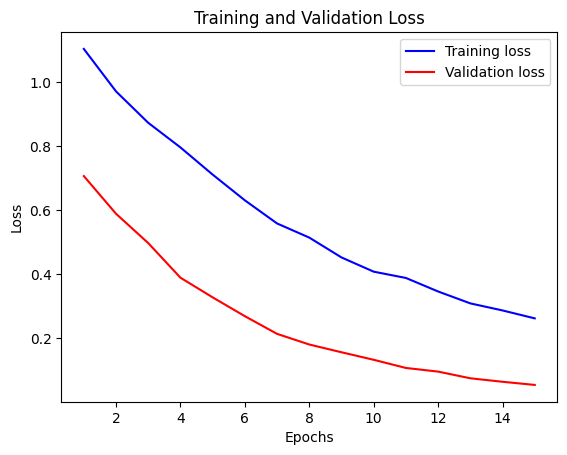

In [15]:
import matplotlib.pyplot as plt
best_val_loss = float('inf')
patience = 2
trigger_times = 0

# Store losses for plotting
train_losses = []
val_losses = []

for epoch in range(15):
    model.train()
    train_loss = 0
    train_batch_count = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        outputs.loss.backward()
        optimizer.step()

        train_loss += outputs.loss.item()
        train_batch_count += 1

    avg_train_loss = train_loss / train_batch_count
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    val_batch_count = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask
            )

            val_loss += outputs.loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Validation loss decreased ({best_val_loss:.4f}). Saving model...")
    else:
        trigger_times += 1
        print(f"Validation loss did not improve for {trigger_times} epoch(s).")
        if trigger_times >= patience:
            print("Early stopping triggered. Stopping training.")
            break


plt.plot(range(1, len(train_losses) + 1), train_losses, 'b', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
model.save_pretrained("models/qg_model")
tokenizer.save_pretrained("models/qg_tokenizer")


('models/qg_tokenizer/tokenizer_config.json',
 'models/qg_tokenizer/special_tokens_map.json',
 'models/qg_tokenizer/spiece.model',
 'models/qg_tokenizer/added_tokens.json',
 'models/qg_tokenizer/tokenizer.json')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
